In [35]:
from cpymad.madx import Madx

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import stats
from scipy.optimize import least_squares as ls
from scipy.optimize import minimize as som

from scipy.optimize import fmin_cobyla


from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# standard configurations
get_ipython().magic('matplotlib inline')
%config InlineBackend.figure_format = 'retina' # retina display

# in order to have fancy plots with lattice
def plotLatticeSeries(ax, series, height=1., v_offset=0., color='r',alpha=0.5,lw=1):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;

# Home-made truncated gaussian distribution
def trun_norm(cut):
    x = np.random.normal()
    return x+cut if np.abs(x)<cut else trun_norm(cut)


from matplotlib import rc

rc('text', usetex=False)
rc('font', serif ='Times')
rc('font', size=16)
rc('axes', linewidth=0.5)
rc('lines', linewidth=1.15	)
rc('figure', figsize=(8.3,5.2))
rc('grid', c='0.5', ls='--', lw=0.5)

In [3]:
myString='''
! *********************************************************************
! Definition of parameters
! *********************************************************************

l_cell=110;
quadrupoleLenght=5;
f=30;
kf:=1/f/quadrupoleLenght;// m^-2
kd:=-1/f/quadrupoleLenght - kf/100;// m^-2

k_corr_1 := 0;
k_corr_2 := 0;

! *********************************************************************
! Definition of magnet
! ********************************************************************* 
QF: quadrupole, L=quadrupoleLenght, K1:=kf;
QD: quadrupole, L=quadrupoleLenght, K1:=kd;

CORR: HKICKER, L=1;
BPM: HMONITOR, L=1;

! *********************************************************************
! Definition of sequence
! *********************************************************************
myCell:sequence, refer=entry, L=L_CELL;
CORR1: CORR, hkick :=k_corr_1, at=0;
QF1: QF, at =10;
CORR2: CORR, hkick :=k_corr_2, at=50;
QD1: QD, at=60;
BPM1: BPM, at=75;
endsequence;

! *********************************************************************
! Definition of beam
! *********************************************************************
beam, particle=proton, energy=2;

! *********************************************************************
! Use of the sequence
! *********************************************************************
use, sequence=myCell;

! *********************************************************************
! TWISS
! *********************************************************************
twiss;
'''



In [4]:
madx = Madx(stdout=False)
#madx = Madx()

madx.input(myString)

dxdy = [trun_norm(2.5) for i in range(2*2)]

madx.input('''
addquaderr(dx_err,dy_err,quadname): macro = {
SELECT, FLAG=error, clear;
eoption, add=false;
SELECT, FLAG=error, PATTERN="quadname";

EALIGN, DX:=0.01*(dx_err-2.5), DY:=0.01*(dy_err-2.5); 
};''');

madx.input('''
exec, addquaderr({},{},QF1);
exec, addquaderr({},{},QD1);

SELECT, FLAG = ERROR, FULL;
ESAVE, FILE = err.txt;

select,flag=interpolate, class=drift, slice=20, range=#s/#e;
twiss;

'''.format(*dxdy))

DF0=madx.table.twiss.dframe()
bpmDF0 = DF0[DF0["keyword"]=="hmonitor"]
qsPos = DF0[DF0["keyword"]=="quadrupole"]

err =madx.table.efield.dframe()
qsERR = err[err["name"].str.contains("q")]

madx.input('''
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
twiss;''')

myTwiss=madx.table.twiss.dframe()


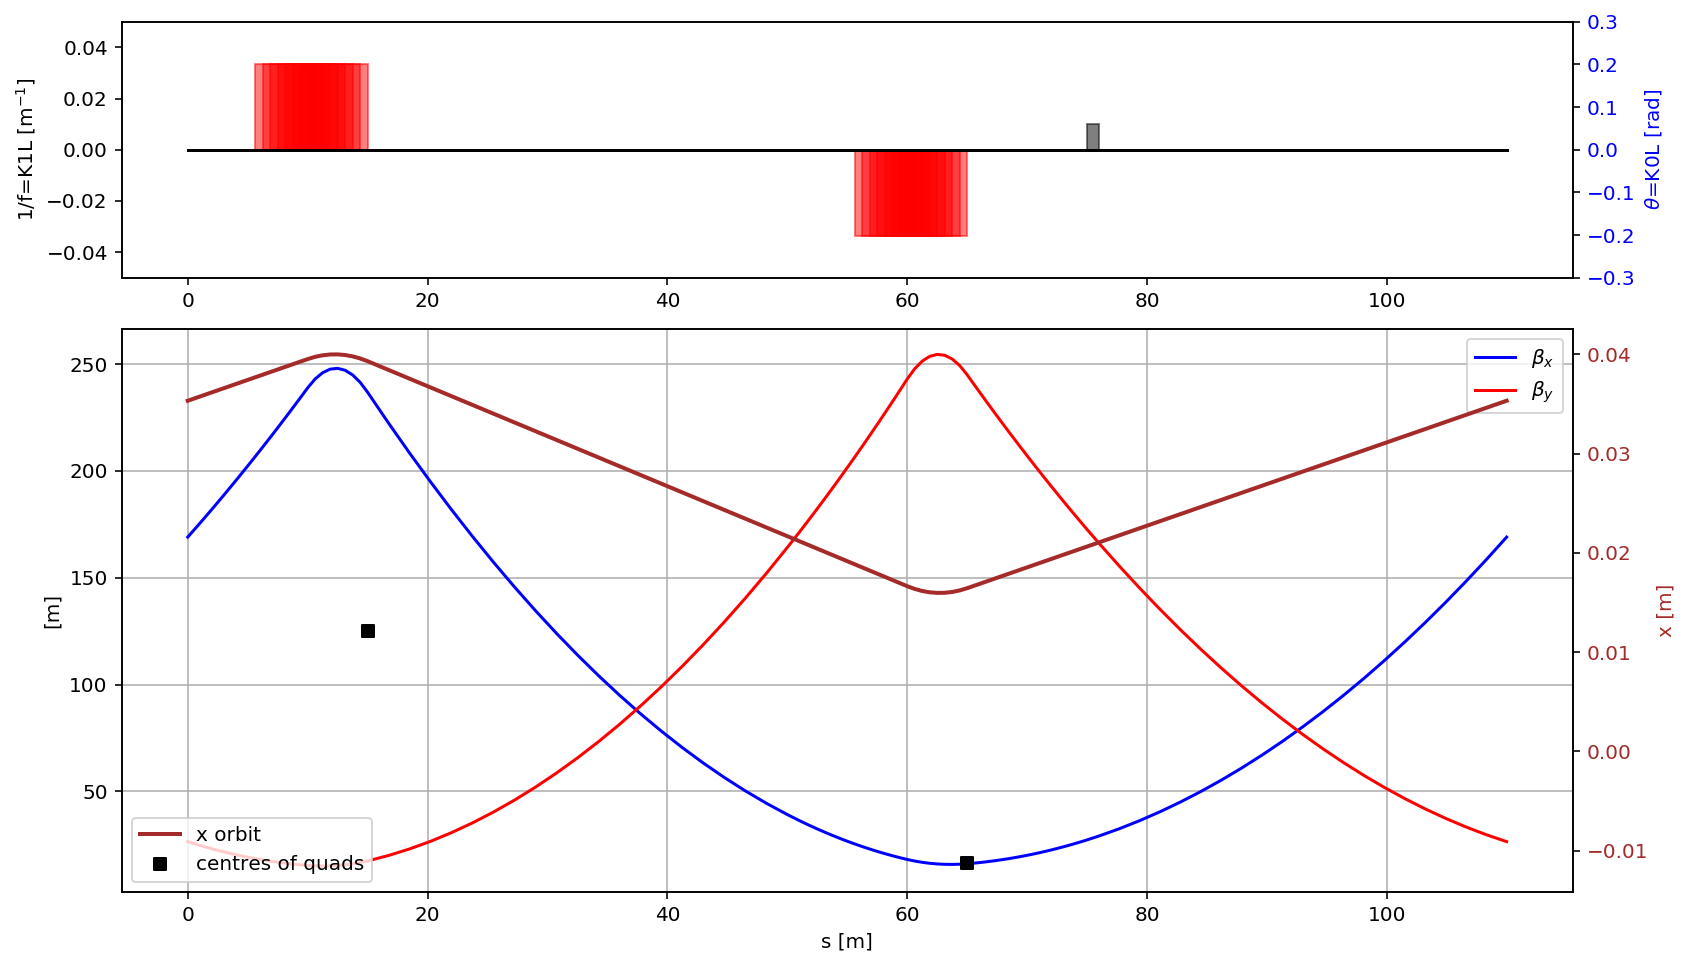

In [5]:
# just plotting
fig = plt.figure(figsize=(13,8))
ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')

DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='hkicker')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.hkick, v_offset=aux.hkick/2, color='blue')
    color = 'red'

DF=myTwiss[(myTwiss['keyword']=='hmonitor')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=0.01, v_offset=0.005, color='black')
    color = 'black'

    
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.05,.05)
#plt.title(f'CAS-19, $\\mu_x$ of the cell={madx.table.summ.Q1[0]/ncell: 2.3f},\
#$\\mu_y$ of the cell={madx.table.summ.Q1[0]/ncell: 2.3f}')
ax2 = ax1.twinx()

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)
ax2.tick_params(axis='y', labelcolor=color)

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k2l, v_offset=aux.k2l/2, color='y')

DF=myTwiss[(myTwiss['keyword']=='sbend')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='b')

    
plt.ylim(-.3,.3)

axbeta=plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.legend(loc='best')

plt.grid()

ax3 = plt.gca().twinx() 
plt.plot(myTwiss['s'],myTwiss['x'],'brown', label='x orbit', lw=2)
plt.scatter(qsPos.s,qsERR.dx, label="centres of quads", marker = "s", color = "black")

ax3.set_ylabel('x [m]', color='brown')
ax3.tick_params(axis='y', labelcolor='brown')
plt.legend(loc='best')
#plt.ylim(0, 10);

In [6]:
# constraint for cobyla here
def con1(x):
    return 0.05*np.sqrt(2)-np.sum(x**2)
    

#=========================================================================================

# scalar function, it is the characterization of full X-orbit
# The argument is numpy array (list of kickers), len = 8
# returns dx/dk
def find_gradient_x(theta):

    
    kf0 =1/30/5
    kd0 =-1/30/5-1/30/5/100
    delta = kf0/10

    madx.input('''kf ={}; kd ={};k_corr_1 = {};k_corr_2 ={};twiss;'''.format(kf0,kd0,*theta));

    aux=madx.table.twiss.dframe()
    xbpm0 =aux[aux["keyword"]=="hmonitor"]["x"]

    madx.input('''kf ={}; kd ={};twiss;'''.format(kf0+delta,kd0+delta));

    aux=madx.table.twiss.dframe()
    xbpm = aux[aux["keyword"]=="hmonitor"]["x"]

    vecf = np.array(xbpm-xbpm0)/delta

    return np.linalg.norm(vecf)


#=========================================================================================



def find_orb_x(theta):
      
    madx.input('''k_corr_1 = {};k_corr_2 ={};
    select,flag=interpolate, class=drift, slice=20, range=#s/#e;
    select,flag=interpolate, class=quadrupole, slice=1, range=#s/#e;
    twiss;
    '''.format(*theta));
    
    aux=madx.table.twiss.dframe()
    xq =aux[aux["keyword"]=="quadrupole"]["x"]
    
    aux =madx.table.efield.dframe()
    Qerr = aux[aux["name"].str.contains("q")]
    
    vec = np.array(np.array(xq)-np.array(Qerr["dx"]))
#    print(vec)

    return np.linalg.norm(vec)




In [7]:
theta_x = np.random.normal(0,0.00001,2)
cons = [{"type": "ineq", "fun": con1}]

vec_xg = som(find_gradient_x, theta_x, method="COBYLA", constraints=cons, options={'rhobeg': .00001, 'disp': True})
vec_xo = som(find_orb_x, theta_x, method="COBYLA", constraints=cons, options={'rhobeg': .00001, 'disp': True})
print(vec_xg)
print(vec_xo)

     fun: 0.13341726169295143
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 48
  status: 1
 success: True
       x: array([-0.00035184, -0.00024841])
     fun: 0.0014311901808548336
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 274
  status: 1
 success: True
       x: array([-0.00161279,  0.00168584])


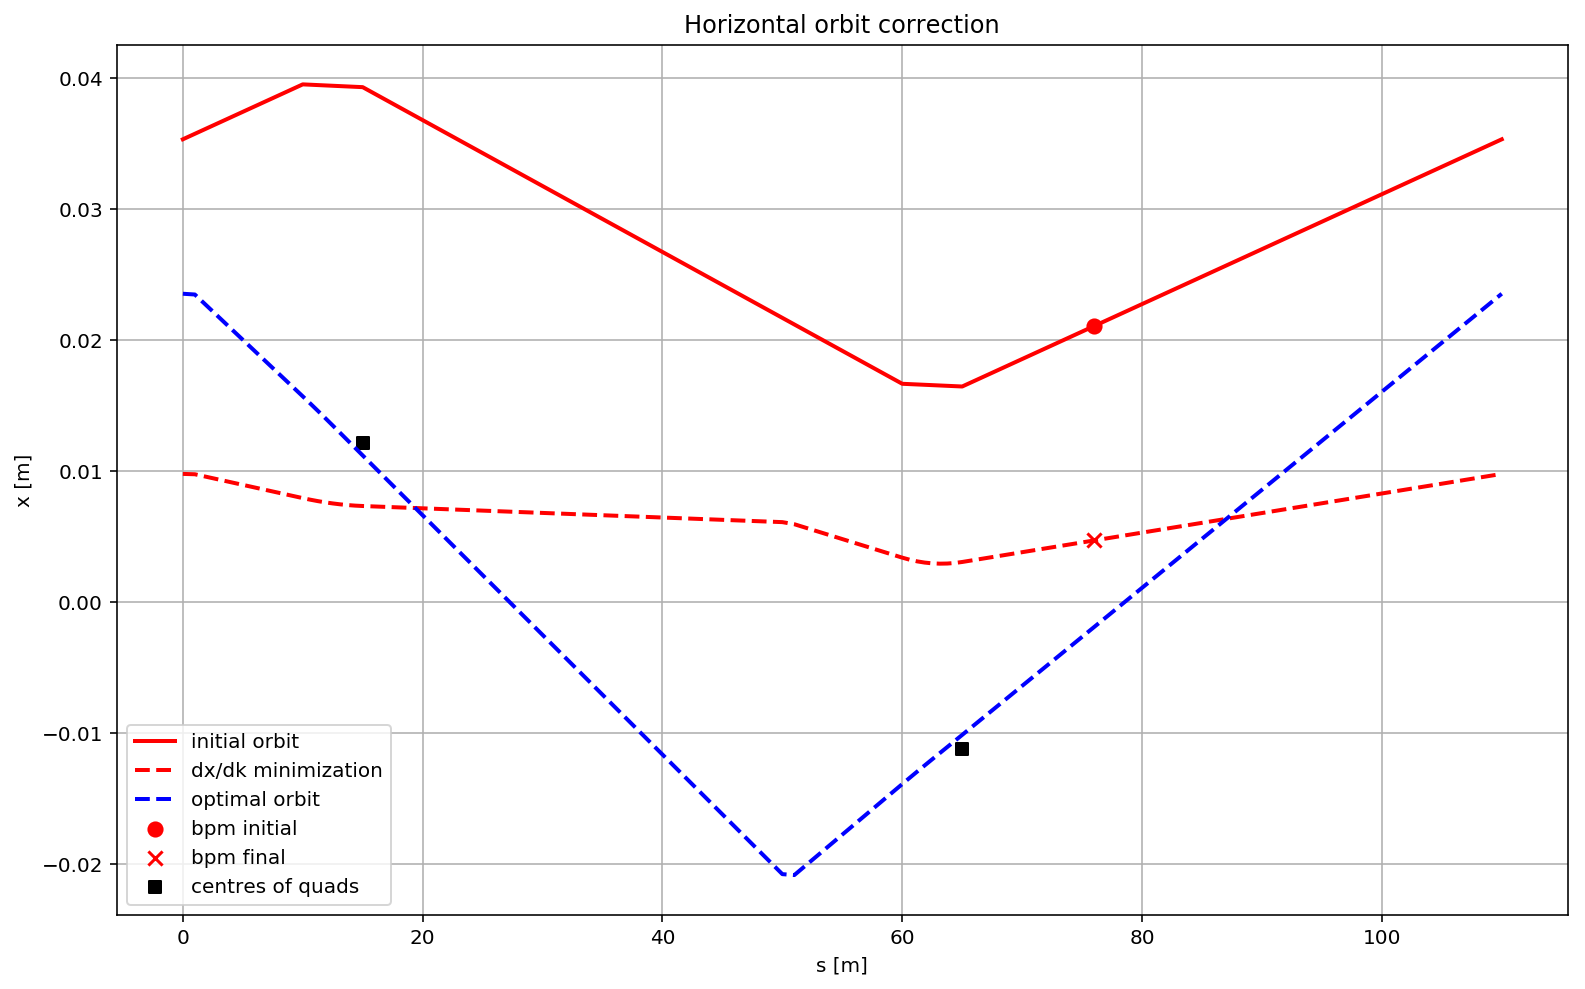

In [8]:
madx.input('''k_corr_1 = {};k_corr_2 ={};
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
twiss;'''.format(*vec_xg.x));

DF=madx.table.twiss.dframe()
bpmDF = DF[DF["keyword"]=="hmonitor"]

madx.input('''k_corr_1 = {};k_corr_2 ={};
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
twiss;'''.format(*vec_xo.x));

DF1=madx.table.twiss.dframe()
bpmDF1 = DF1[DF1["keyword"]=="hmonitor"]

# plotting
# red dashed line stands for find_grad, blue dashed for find_orb

fig = plt.figure(figsize=(13,8))
plt.plot(DF0['s'],DF0['x'],'r', label='initial orbit', lw=2)
plt.scatter(bpmDF0.s,bpmDF0.x, color = "red", s = 50, label="bpm initial")

plt.plot(DF['s'],DF['x'],'r',ls="--", label='dx/dk minimization', lw=2)
plt.scatter(bpmDF.s,bpmDF.x, color = "red", s = 50, marker="x", label="bpm final")

plt.plot(DF1['s'],DF1['x'],'blue',ls="--", label='optimal orbit', lw=2)

plt.scatter(qsPos.s,qsERR.dx, label="centres of quads", marker = "s", color = "black")

plt.legend(loc='best')
plt.title("Horizontal orbit correction")
plt.ylabel('x [m]')
plt.xlabel('s [m]')
plt.grid()


In [13]:
# this method applies errors to the lattice
# note, that all correctors are set to zero here
def add_err():

    dxdy = [trun_norm(2.5) for i in range(2*2)]

    out =madx.input('''
    
    k_corr_1 = 0.0;k_corr_2 = 0.0;
    
    exec, addquaderr({},{},QF1);
    exec, addquaderr({},{},QD1);

    SELECT, FLAG = ERROR, FULL;
    ESAVE, FILE = err.txt;

    twiss;

    '''.format(*dxdy))
    return out




In [18]:

#df = pd.DataFrame(columns=["x(0)","dx/dk(0)"])

def make_train_data():

    df_tmp = pd.DataFrame(columns=["x(0)","dx/dk(0)","n", "theta_1", "theta_2"])

    for i in range(100):
        a = add_err()
        if a:
            aux=madx.table.twiss.dframe()
            x0 = np.array(aux[aux["keyword"]=="hmonitor"]["x"])[0]
            dxdk0 =find_gradient_x(np.zeros(2))
        
            theta_x = np.zeros(2)
            vec = som(find_orb_x, theta_x, method="COBYLA", constraints=cons, options={'rhobeg': .00001, 'disp': True})

            #this step is required to indetify, where the optimizer found totally wrong sollution
            if dxdk0 > find_gradient_x(vec.x):
                df_tmp =df_tmp.append({"x(0)":x0,"dx/dk(0)":dxdk0, "n":vec.nfev,"dx":vec.fun, "theta_1":vec.x[0], "theta_2":vec.x[1]},ignore_index=True)
            else:
                print("warn! the optimum sollution not found")
            
    return df_tmp


    

df = make_train_data()
#df.to_csv("inverse_regression.csv",index=False)

#df = pd.read_csv("inverse_regression.csv")

warn! the optimum sollution not found


In [63]:
max_depth = 2
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,max_depth=max_depth, random_state=10))

regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=2)

feature_cols = ["x(0)","dx/dk(0)"]
target_cols = ["theta_1","theta_2"]

A = np.linalg.norm(df[target_cols])
X = df[feature_cols]
Y = df[target_cols]/A
n = len(df)
#print(n)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=int(8*n/10), test_size=n-int(8*n/10), random_state=1)

regr_multirf.fit(X_train, Y_train)
y_multirf = regr_multirf.predict(X_test)

regr_rf.fit(X_train, Y_train)
y_rf = regr_rf.predict(X_test)


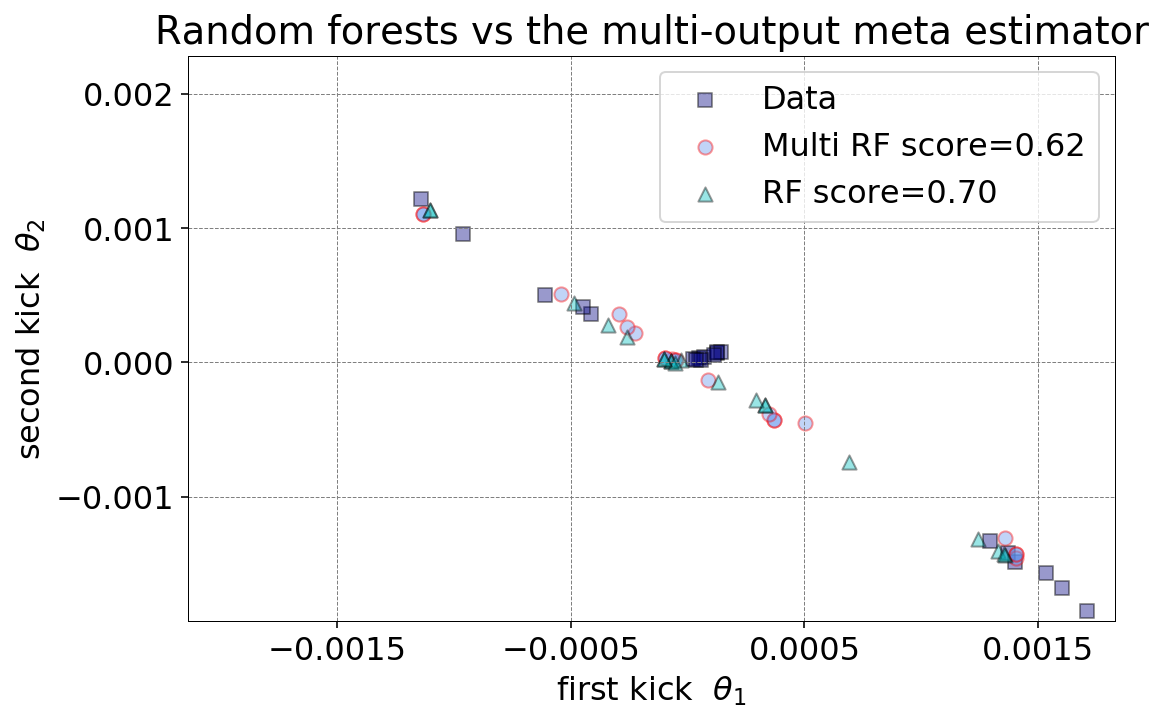

In [103]:
plt.figure()
s = 50
a = 0.4
plt.scatter(Y_test["theta_1"]*A, Y_test["theta_2"]*A, edgecolor='k', c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(y_multirf[:, 0]*A, y_multirf[:, 1]*A, edgecolor='r',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(X_test, Y_test))
plt.scatter(y_rf[:, 0]*A, y_rf[:, 1]*A, edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="RF score=%.2f" % regr_rf.score(X_test, Y_test))

plt.xlim([df["theta_1"].min(), df["theta_1"].max()])
plt.ylim([df["theta_2"].min(), df["theta_2"].max()])

plt.xlabel(r"first kick  $\theta_1$")
plt.ylabel(r"second kick  $\theta_2$")
plt.title("Random forests vs the multi-output meta estimator")
plt.legend()
plt.grid(True)
plt.xticks(np.arange(-0.0015, 0.002, 0.001))
plt.show()
#plt.savefig("rf_vs_mrf.pdf")

In [109]:
add_err()
DF0=madx.table.twiss.dframe()
x0 = np.array(DF0[DF0["keyword"]=="hmonitor"]["x"])[0]
dxdk0 =find_gradient_x(np.zeros(2))

vec_predict_mrf = regr_multirf.predict([[x0,dxdk0]])*A
vec_predict_rf = regr_rf.predict([[x0,dxdk0]])*A

err1 =madx.table.efield.dframe()
qsERR1 = err1[err1["name"].str.contains("q")]
qsPos1 = DF0[DF0["keyword"]=="quadrupole"]


In [110]:
vec_xg_dt = som(find_gradient_x, vec_predict_rf[0], method="COBYLA", constraints=cons, options={'rhobeg': .00001, 'disp': True})

vec_xg = som(find_gradient_x, np.zeros(2), method="COBYLA", constraints=cons, options={'rhobeg': .00001, 'disp': True})
vec_xo = som(find_orb_x, np.zeros(2), method="COBYLA", constraints=cons, options={'rhobeg': .00001, 'disp': True})

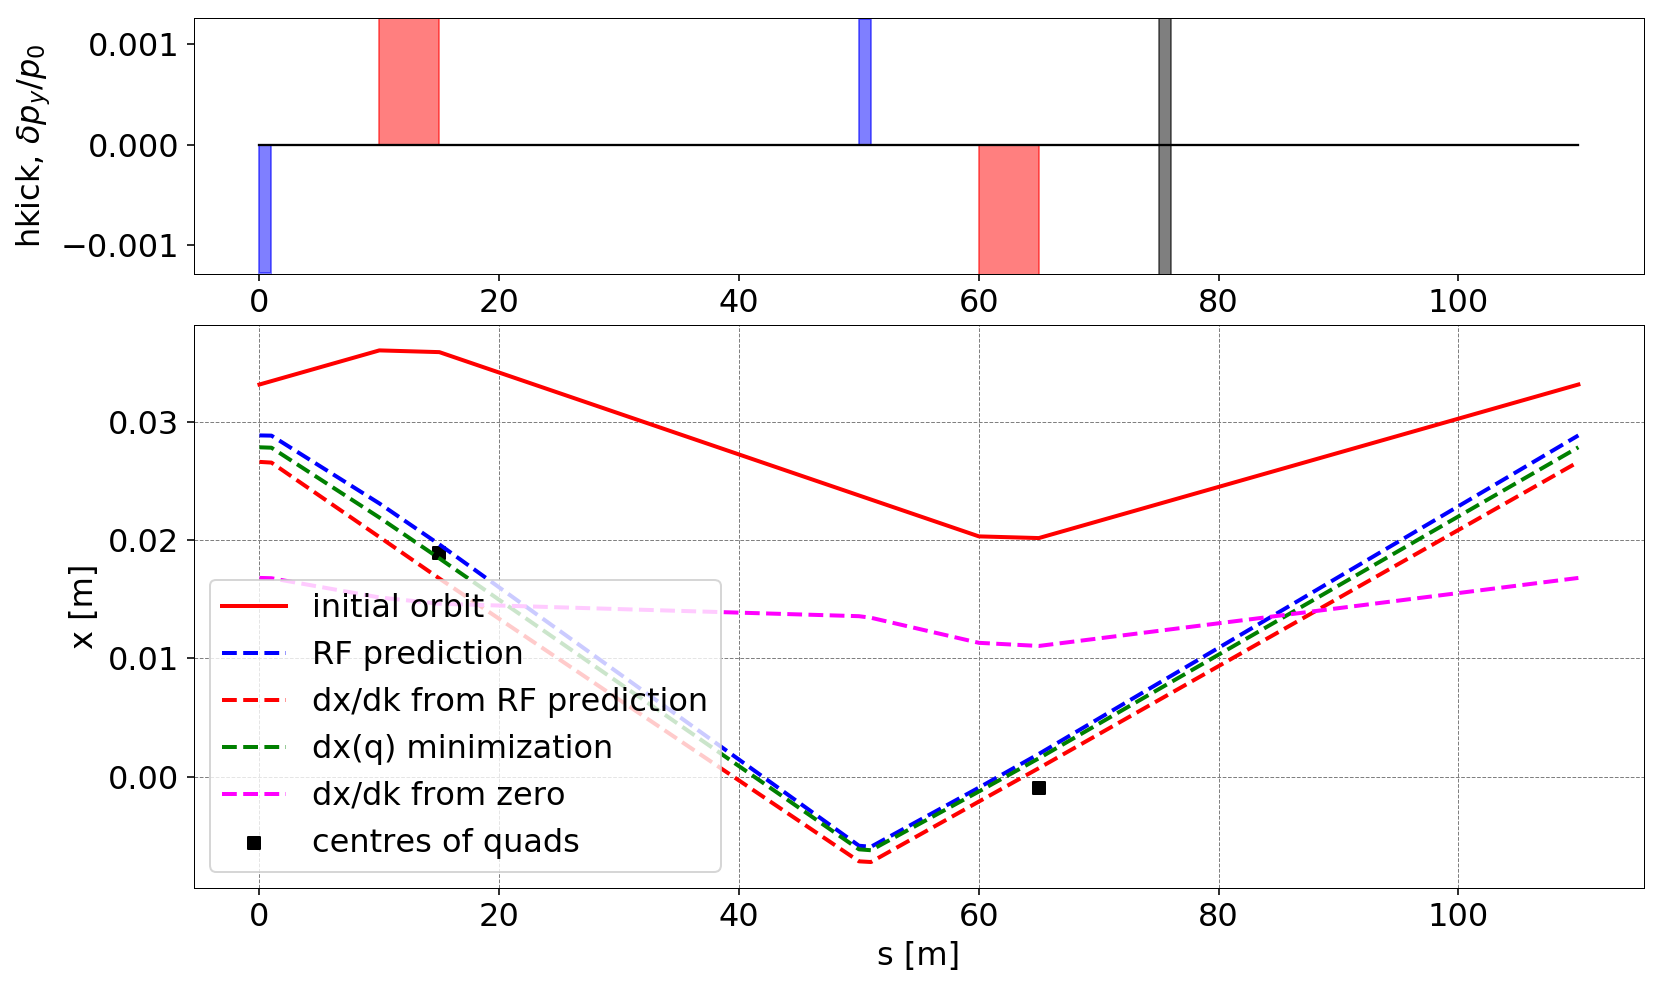

In [111]:
madx.input('''k_corr_1 = {};k_corr_2 ={};
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
!select,flag=interpolate, class=quadrupole, slice=1, range=#s/#e;
twiss;'''.format(*vec_predict_rf[0]));

DF=madx.table.twiss.dframe()

madx.input('''k_corr_1 = {};k_corr_2 ={};twiss;'''.format(*vec_xg_dt.x));

DF1=madx.table.twiss.dframe()
bpmDF1 = DF1[DF1["keyword"]=="hmonitor"]


madx.input('''k_corr_1 = {};k_corr_2 ={};twiss;'''.format(*vec_xo.x));

DF2=madx.table.twiss.dframe()

madx.input('''k_corr_1 = {};k_corr_2 ={};twiss;'''.format(*vec_xg.x));

DF3=madx.table.twiss.dframe()

# plotting
fig = plt.figure(figsize=(13,8))
ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')

tmp=DF1[DF1['keyword']=='quadrupole']
for i in range(len(tmp)):
    aux=tmp.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

hk = []
tmp=DF1[(DF1['keyword']=='hkicker')]
for i in range(len(tmp)):
    aux=tmp.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.hkick, v_offset=aux.hkick/2, color='blue')
    hk.append(aux.hkick)
    color = 'red'

tmp=DF1[(DF1['keyword']=='hmonitor')]
for i in range(len(tmp)):
    aux=tmp.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=0.01, v_offset=0.005, color='black')
    plotLatticeSeries(plt.gca(),aux, height=0.01, v_offset=-0.005, color='black')
    color = 'black'

    
ax1.set_ylabel(r'hkick, $\delta p_y /p_0$', color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(min(hk)-10**(-5),max(hk)+10**(-5))

axbeta=plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)


plt.plot(DF0['s'],DF0['x'],'r', label='initial orbit', lw=2)

plt.plot(DF['s'],DF['x'],'blue',ls="--", label='RF prediction', lw=2)
plt.plot(DF1['s'],DF1['x'],'red',ls="--", label='dx/dk from RF prediction', lw=2)
plt.plot(DF2['s'],DF2['x'],'green',ls="--", label='dx(q) minimization', lw=2)
plt.plot(DF3['s'],DF3['x'],'magenta',ls="--", label='dx/dk from zero', lw=2)

#plt.scatter(bpmDF1.s,bpmDF1.x, color = "red", s = 50, marker="x", label="bpm final")
plt.scatter(qsPos1.s,qsERR1.dx, label="centres of quads", marker = "s", color = "black")

plt.legend(loc='best')
#plt.title("Horizontal orbit correction")
plt.ylabel('x [m]')
plt.xlabel('s [m]')
plt.grid()

#plt.savefig("FODO_corr.pdf")

In [112]:
vectors = [np.zeros(2),vec_predict_mrf[0],vec_predict_rf[0], vec_xg, vec_xg_dt, vec_xo]
names = ["zero","MRF prediction", "RF prediction", "dx/dk from zero", "dx/dk from prediction", "dx(q) from zero"]
df1 = pd.DataFrame(columns=["type","final dx/dk","final dx(q)", "opt. steps"])

for i,vec in enumerate(vectors):
    if i>2:
        g = find_gradient_x(vec.x)
        qo = find_orb_x(vec.x)
        n = vec.nfev
    else:
        g = find_gradient_x(vec)
        qo = find_orb_x(vec)
        n = 1
    df1 = df1.append({"type":names[i],"final dx/dk":g,"final dx(q)":qo, "opt. steps":n}, ignore_index=True)
    
df1

,type,final dx/dk,final dx(q),opt. steps
0,zero,4.777449,0.027064,1
1,MRF prediction,0.817828,0.003340,1
2,RF prediction,0.592635,0.002948,1
3,dx/dk from zero,0.168726,0.012729,41
4,dx/dk from prediction,0.075805,0.002727,10
5,dx(q) from zero,0.323635,0.002533,213
